In [52]:
import pandas as pd
import datetime as dt
import folium
import matplotlib.pyplot as plt

# Data preparation

In [53]:
data = pd.read_csv("data.csv")

# Feature engeneering
data['avg_speed'] = data['avg_km']/data['avg_sec']*3600 # km/h
data['date_hour'] = pd.to_datetime(data['date_hour'])
data['month'] = data['date_hour'].dt.month
data['day'] = data['date_hour'].dt.day
data['hour'] = data['date_hour'].dt.hour
data['dayofweek'] = data['date_hour'].dt.dayofweek
data.drop(columns=['date_hour'], inplace=True)

In [54]:
data = data[['zone_id','month',
       'day', 'hour', 'dayofweek', 'n_rides', 'avg_sec',
       'avg_km', 'avg_speed','start_h3', 'end_h3','start_h3_centroid_lat', 'start_h3_centroid_lon',
       'end_h3_centroid_lat', 'end_h3_centroid_lon']]

# Data exploration

In [55]:
data

,zone_id,month,day,hour,dayofweek,n_rides,avg_sec,avg_km,avg_speed,start_h3,end_h3,start_h3_centroid_lat,start_h3_centroid_lon,end_h3_centroid_lat,end_h3_centroid_lon
0,berlin,7,1,0,0,1,7204.408,1.009574,0.504478,8a1f1d4d0d5ffff,8a1f1d4d0057fff,52.515059,13.453406,52.511310,13.467112
1,berlin,7,1,0,0,1,6927.627,0.018491,0.009609,8a1f1d4f2557fff,8a1f1d4f2557fff,52.540292,13.416662,52.540292,13.416662
2,berlin,7,1,0,0,1,6596.358,1.535732,0.838134,8a1f1d4f255ffff,8a1f1d4899b7fff,52.540052,13.418495,52.532886,13.399084
3,berlin,7,1,0,0,1,7205.306,1.106335,0.552760,8a1f1d4f255ffff,8a1f1d48da4ffff,52.540052,13.418495,52.547429,13.406683
4,berlin,7,1,0,0,1,7201.344,0.339569,0.169753,8a1f1d4f640ffff,8a1f1d4f6577fff,52.554323,13.398535,52.557409,13.397211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611377,munich,12,31,15,1,1,612.658,0.865500,5.085707,8a1f8d7a482ffff,8a1f8d44b4cffff,48.138543,11.579964,48.140956,11.591940
611378,munich,12,31,16,1,1,1175.794,1.488641,4.557863,8a1f8d44a2c7fff,8a1f8d44a8d7fff,48.142891,11.578211,48.151346,11.561852
611379,munich,12,31,21,1,1,296.046,0.140860,1.712897,8a1f8d459057fff,8a1f8d4593b7fff,48.127069,11.552222,48.125741,11.554376
611380,munich,12,31,23,1,1,460.668,0.331242,2.588568,8a1f8d4593b7fff,8a1f8d459747fff,48.125741,11.554376,48.122721,11.553976


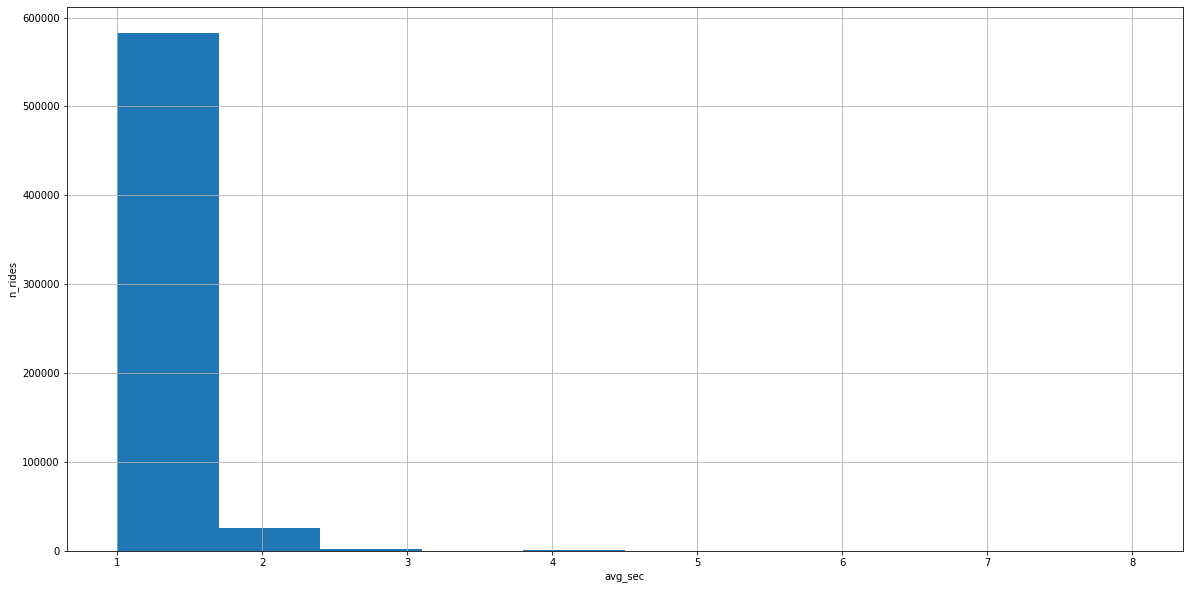

In [56]:
plt.figure(figsize=(20,10))
plt.hist(data['n_rides'])
plt.grid()
plt.xlabel('avg_sec')
plt.ylabel('n_rides')
plt.show()

Strefy są na tyle małe, że zazwyczaj jeden wiersz przedsttawia tylko jeden przejazd

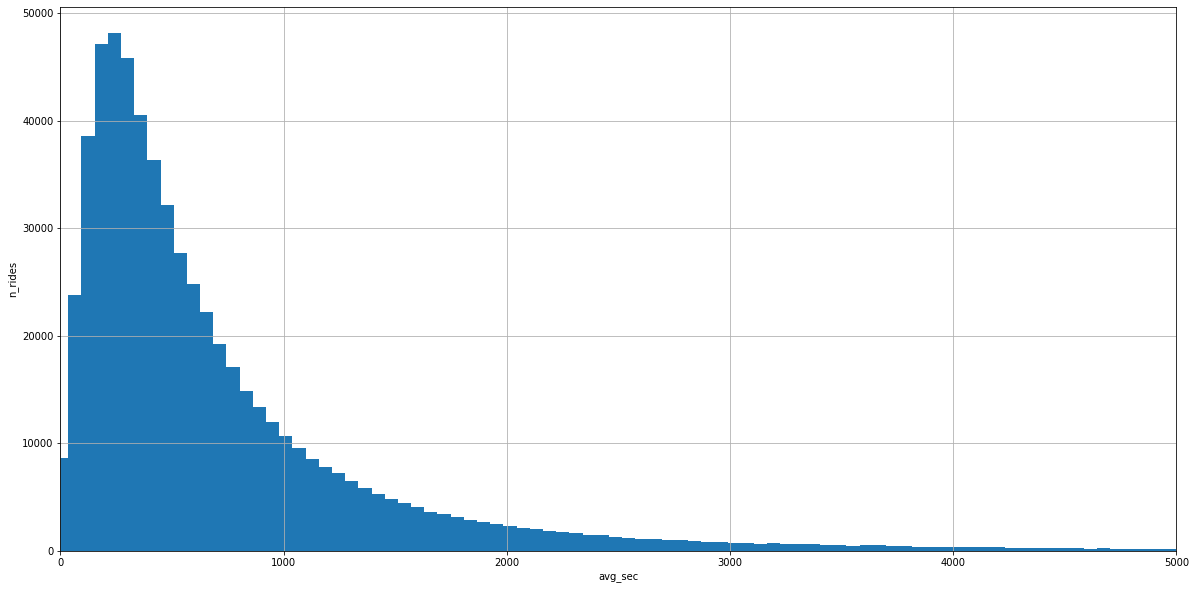

In [57]:
plt.figure(figsize=(20,10))
plt.hist(data['avg_sec']*data['n_rides'],bins=500)
plt.grid()
plt.xlim([0, 5000])
plt.xlabel('avg_sec')
plt.ylabel('n_rides')
plt.show()

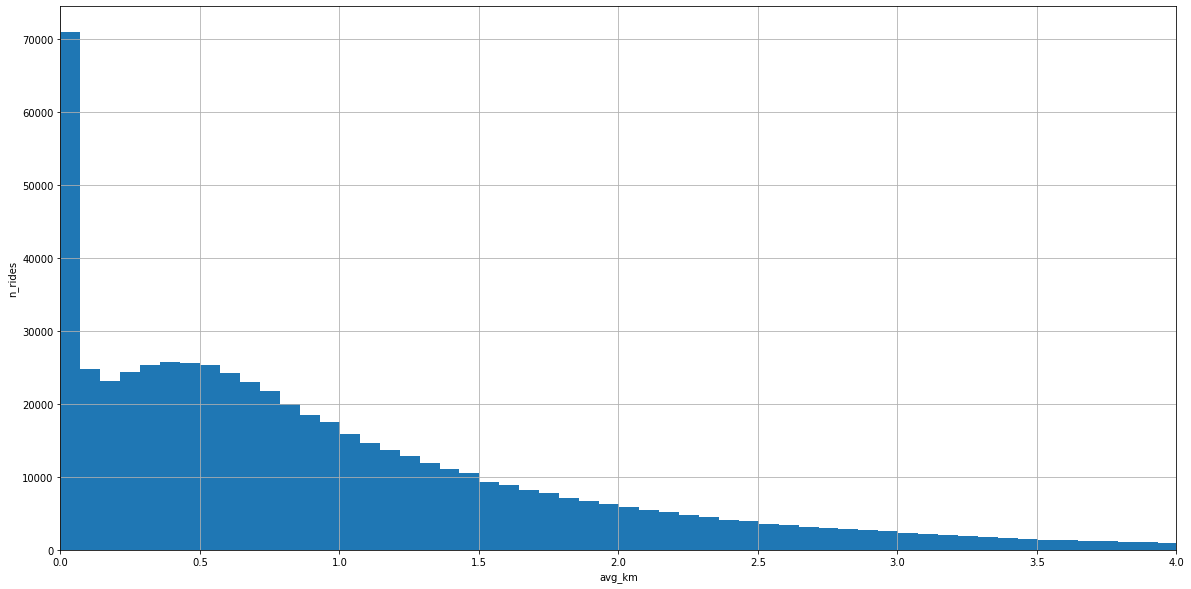

In [58]:
plt.figure(figsize=(20,10))
plt.hist(data['avg_km']*data['n_rides'],bins=500)
plt.grid()
plt.xlim([0, 4])
plt.xlabel('avg_km')
plt.ylabel('n_rides')
plt.show()

In [59]:
print(f"Unikalne strefy:\n Berlin {len(data[data['zone_id']=='berlin']['start_h3'].unique())}\n Monachium: {len(data[data['zone_id']=='munich']['start_h3'].unique())}")

Unikalne strefy:
 Berlin 7562
 Monachium: 3438


In [60]:
print(f"Liczba przejazdów:\n Berlin {len(data[data['zone_id']=='berlin']['n_rides'])}\n Monachium: {len(data[data['zone_id']=='munich']['n_rides'])}")

Liczba przejazdów:
 Berlin 364598
 Monachium: 246784


<AxesSubplot:xlabel='month'>

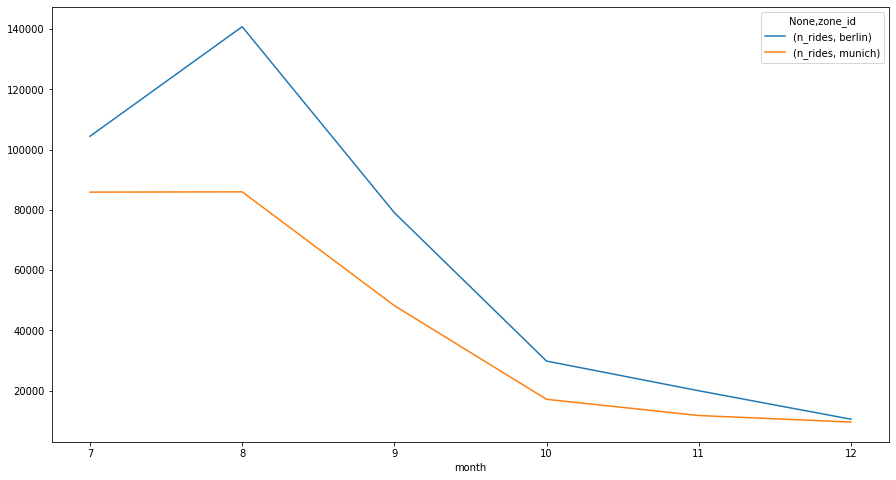

In [76]:
pd.pivot_table(data, values=['n_rides'],  index=data['month'], columns=['zone_id'], aggfunc='sum').plot(figsize=(15,8))

<AxesSubplot:xlabel='month,day'>

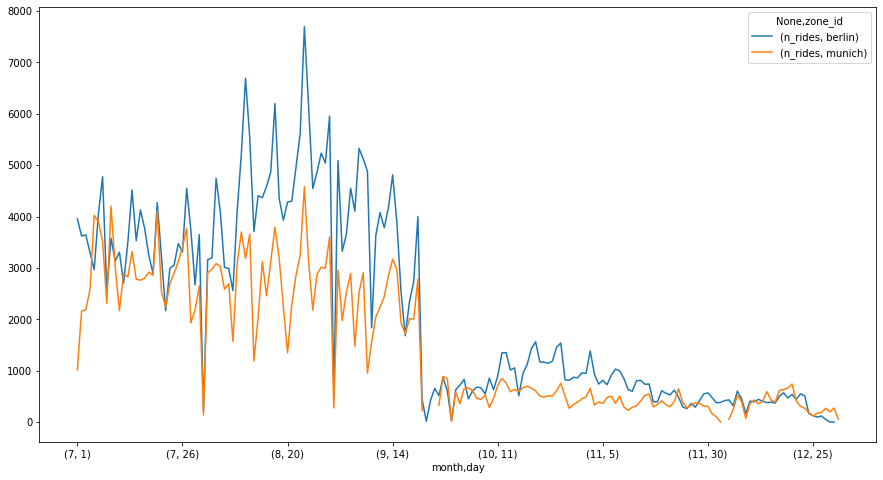

In [74]:
pd.pivot_table(data, values=['n_rides'],  index=data[['month','day']], columns=['zone_id'], aggfunc='sum').plot(figsize=(15,8))

<AxesSubplot:xlabel='dayofweek'>

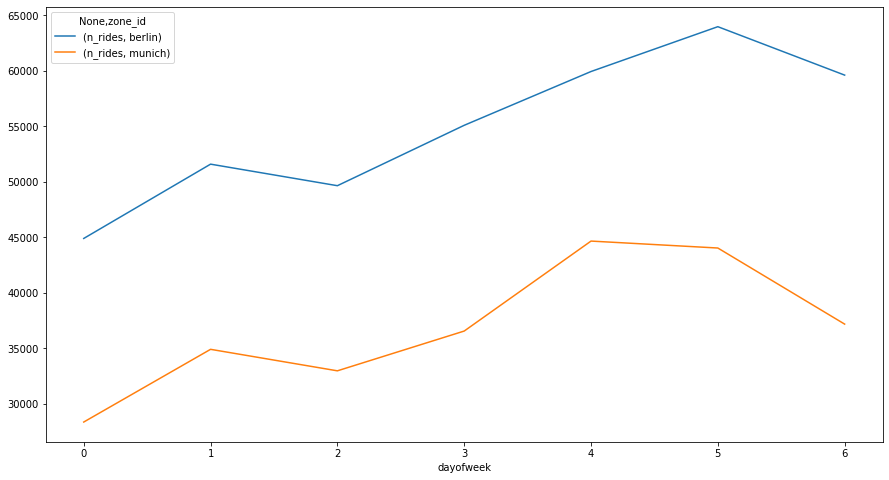

In [73]:
pd.pivot_table(data, values=['n_rides'],  index=data[['dayofweek']], columns=['zone_id'], aggfunc='sum').plot(figsize=(15,8))

In [66]:
def getRide(i):
    return  [[data['start_h3_centroid_lat'][i], data['start_h3_centroid_lon'][i]], [data['end_h3_centroid_lat'][i], data['end_h3_centroid_lon'][i]]]

rides = []
for i in range(300):
    rides += [getRide(i)]

map = folium.Map(location=[52.540052, 13.418495])
folium.PolyLine(rides, color="red", weight=2.5, opacity=1).add_to(map)
map